In [2]:
import sys
sys.path.insert(0, 'evoman')
from environment import Environment
from demo_controller import player_controller

import time
import numpy as np
import glob, os
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

pygame 2.0.0.dev10 (SDL 2.0.12, python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Initialize functions for evolution

In [2]:
def fitness(x):
    def play(y):
        fit, play, enem, time = env.play(pcont=y)
        return (fit, play, enem)
    return np.array(list(map(lambda z: play(z), x)))

In [3]:
def parentselect(pop_fitness,s,exp_rank=True):
    pop_frame = pd.DataFrame(pop_fitness,columns=['fitness']).reset_index()
    pop_sort = pop_frame.sort_values(axis=0,by='fitness')
    pop_sort = pop_sort.reset_index(drop=True).reset_index().rename(columns={'level_0':'rank','index':'pop_index','0':'fitness'})
    mu = len(pop_sort)
    rank = pop_sort['rank']
    if exp_rank:
        c = 0
        for i in range(mu):
            c += (1-np.exp(-i))
        p_parent = (1-np.exp(-rank))/c
    else:
        p_parent = (2-s)/mu+2*rank*(s-1)/(mu*(mu-1))
    pop_sort['p_parent'] = p_parent
    parent_index = np.random.choice(pop_sort['pop_index'],1,p=pop_sort['p_parent'],replace=False)
    return parent_index

In [4]:
def create_offspring(pop,s,current_gen,gen,exp_rank=True,simple=False):
    os_pop = np.zeros((0,nvar))
    if simple:
        for parent in range(0,pop.shape[0],2):
            parent1 = pop[parentselect(pop_fitness,s,exp_rank)]
            parent2 = pop[parentselect(pop_fitness,s,exp_rank)]
            n_os = np.random.randint(1,3,1)[0]
            os = np.zeros((n_os,nvar))
            for i in range(n_os):
                alpha = np.random.uniform(0,1)
                os[i] = alpha*parent1 + (1-alpha)*parent2
                if np.random.uniform(0,1) <= np.linspace(0.5,0.1,gen)[current_gen]:
                    os[i] = os[i] + np.random.normal(0,np.linspace(3,1,gen)[current_gen],nvar)
                os_pop = np.vstack((os_pop, os[i]))
    else:
        for parent in range(0,pop.shape[0],2):
            parent1 = pop[parentselect(pop_fitness,s,exp_rank)]
            parent2 = pop[parentselect(pop_fitness,s,exp_rank)]
            n_os = np.random.randint(1,5,1)[0]
            os = np.zeros((n_os,nvar))
            for i in range(n_os):
                alpha = np.random.uniform(0,1)
                os[i] = alpha*parent1 + (1-alpha)*parent2
                for j in range(len(os[i])):
                    if np.random.uniform(0,1) <= np.linspace(0.5,0.1,gen)[current_gen]:
                        os[i][j] = os[i][j] + np.random.normal(0,np.linspace(3,1,gen)[current_gen])
                os_pop = np.vstack((os_pop, os[i]))
    return os_pop

In [5]:
def mulambda(pop_fitness): #could extend to mu,lambda
    pop_sort = pd.DataFrame(pop_fitness,columns=['fitness']).reset_index().sort_values(by='fitness',ascending=False)
    pop_sort = pop_sort.reset_index(drop=True)
    return pop_sort.loc[0:npop-1,'index']

In [6]:
def roundrobin(pop_fitness,q,best=True):
    pop_wins = pd.DataFrame(pop_fitness,columns=['fitness']).reset_index()
    pop_wins['wins'] = np.zeros(len(pop_fitness))
    for i in range(len(pop_wins)):
        opps = random.sample(range(0,len(pop_wins)),q)
        while i in opps:
            opps[opps.index(i)] = random.sample(range(0,len(pop_wins)),1)[0]
        for j in opps:
            if pop_wins.loc[i,'fitness'] > pop_wins.loc[j,'fitness']:
                pop_wins.loc[i,'wins'] += 1
    pop_wins.sort_values(by='wins',inplace=True,ascending=False)
    pop_wins = pop_wins.reset_index(drop=True)
    if best: #make sure best individual stays
        best_ind = pop_wins.loc[np.argmax(pop_wins['fitness']),'index']
        return np.append(np.array(pop_wins.loc[0:npop-2,'index']),best_ind)
    else:
        return pop_wins.loc[0:npop-1,'index']   

In [7]:
def sweep(pop,pop_fitness,drop=0.2):
    pop_sweep = pd.DataFrame(pop_fitness,columns=['fitness']).reset_index().sort_values(by='fitness',ascending=False).reset_index(drop=True)
    drop_index = round(len(pop_sweep)*(1-drop))
    pop_sweep = pop_sweep[0:drop_index]
    repl_length = (len(pop)-drop_index,nvar)
    repl = np.random.uniform(llimit, ulimit, repl_length)
    repl_eval = fitness(repl)
    repl_fitness = list(map(lambda z: z[0], repl_eval))
    pop = pop[np.array(pop_sweep['index'])]
    pop = np.vstack((pop,repl))
    pop_fitness = np.array(pop_fitness)[np.array(pop_sweep['index'])]
    pop_fitness = np.append(pop_fitness,repl_fitness)
    return pop, pop_fitness

### Run evolution for 10 and 40 nodeEA


In [8]:
for enemy in [[1,6,7],[2,4,8]]:
    experiment = '40nodes'+str(enemy)
    if not os.path.exists(experiment):
        os.makedirs(experiment)

    #initialize environment
    reps = 10
    nnode1 = 40
    env = Environment(experiment_name=experiment,enemies=enemy,multiplemode="yes",
                        playermode="ai",player_controller=player_controller(nnode1),
                        enemymode="static",level=2,speed="fastest",logs ='off')
    nvar = (env.get_num_sensors()+1)*nnode1 + (nnode1+1)*5

    ulimit = 1
    llimit = -1
    npop=30
    popsize = (npop, nvar)
    gen=30
    np.random.seed(12)
    best_fit_total = np.zeros((0,0))
    best_ind_total = pd.DataFrame()
    for r in range(reps):#initialize population
        start = time.time()
        pop = np.random.uniform(llimit, ulimit, popsize)
        evaluation = fitness(pop)
        pop_fitness = list(map(lambda z: z[0], evaluation))
        #pop_life = list(map(lambda z: z[1], evaluation))
        #pop_enem = list(map(lambda z: z[2], evaluation))
        total_fitness = pd.DataFrame(pop_fitness).T
        #total_life = pd.DataFrame(pop_life).T
        #total_enem = pd.DataFrame(pop_enem).T
        best_fit, avg_fit, std_fit = np.array(pop_fitness[np.argmax(pop_fitness)]), np.array(np.mean(pop_fitness)), np.array(np.std(pop_fitness))
        unimproved = 0
        for i in range(gen):
            print( '\nGeneration: '+str(r)+'.'+str(i))
            print('calculating pop_fit')

            #create offspring and evaluate
            offspring = create_offspring(pop,1.5,i,gen,exp_rank=True,simple=True)
            print('calculating os_fit')
            os_evaluation = fitness(offspring)
            os_fitness = list(map(lambda z: z[0], os_evaluation))
            #stack parents and offspring (and their fitness)
            pop = np.vstack((pop,offspring))
            pop_fitness = np.append(pop_fitness,os_fitness)
            #round robin to determine survivors
            index = mulambda(pop_fitness)
            pop = pop[index]
            evaluation = fitness(pop)
            pop_fitness = list(map(lambda z: z[0], evaluation))
            #pop_life = np.array(list(map(lambda z: z[1], evaluation)))
            #pop_enem = np.array(list(map(lambda z: z[2], evaluation)))
            #pop_IG = pop_life-pop_enem
            #append information on generations
            total_fitness = total_fitness.append(pd.Series(pop_fitness),ignore_index=True)
            #total_life = total_life.append(pd.Series(pop_life),ignore_index=True)
            #total_enem = total_enem.append(pd.Series(pop_enem),ignore_index=True)
            #best_IG = pop_IG[np.argmax(pop_IG)]
            best_ind = pop[np.argmax(pop_fitness)]
            best_fit2 = pop_fitness[np.argmax(pop_fitness)]
            best_fit = np.append(best_fit,pop_fitness[np.argmax(pop_fitness)])
            avg_fit = np.append(avg_fit,np.mean(pop_fitness))
            std_fit = np.append(std_fit,np.std(pop_fitness))
            #sweep population when unimproved for 5 times
            if best_fit[i] <= best_fit[i-1]:
                unimproved += 1
            elif best_fit[i] > best_fit[i-1]+1:
                unimproved = 0
            if unimproved > 5:
                pop, pop_fitness = sweep(pop,pop_fitness,0.3)
                unimproved = 0
            print(str(unimproved)+' unimproved steps')
            print( '\nBest fitness: '+str(round(best_fit[i],2))+'\tAvg fitness: '+str(round(avg_fit[i],2)))

        best_fit_total = pd.DataFrame(np.append(best_fit_total,best_fit2))
        best_ind_total = best_ind_total.append(pd.Series(best_ind),ignore_index=True)


        #save accumulated data
        fitness_data = pd.DataFrame({'Best fitness':best_fit,'Avg fitness':avg_fit,'Std fitness':std_fit})
        if not os.path.exists(experiment+'/rep'+str(r)):
            os.makedirs(experiment+'/rep'+str(r))
        fitness_data.to_csv(experiment+'/rep'+str(r)+'/fitstats.csv',index=True)
        total_fitness.to_csv(experiment+'/rep'+str(r)+'/fitness.csv',index=True)
        #total_IG = total_life-total_enem
        #total_IG.to_csv(experiment+'/rep'+str(r)+'/IG.csv',index=True)

        end = time.time()
        print('\nExcecution time: '+str(round(end-start))+' seconds')
    best_fit_total.to_csv(experiment+'/best_fits.csv',index=True)
    best_ind_total.to_csv(experiment+'/best_indivs.csv',index=True)




Generation: 0.0
calculating pop_fit
calculating os_fit
1 unimproved steps

Best fitness: -3.35	Avg fitness: -6.72

Generation: 0.1
calculating pop_fit
calculating os_fit
2 unimproved steps

Best fitness: -3.35	Avg fitness: -5.63

Generation: 0.2
calculating pop_fit
calculating os_fit
0 unimproved steps

Best fitness: 24.22	Avg fitness: -4.4

Generation: 0.3
calculating pop_fit
calculating os_fit
1 unimproved steps

Best fitness: 24.22	Avg fitness: -3.52

Generation: 0.4
calculating pop_fit
calculating os_fit
2 unimproved steps

Best fitness: 24.22	Avg fitness: -3.09

Generation: 0.5
calculating pop_fit
calculating os_fit
3 unimproved steps

Best fitness: 24.22	Avg fitness: -0.39

Generation: 0.6
calculating pop_fit
calculating os_fit
4 unimproved steps

Best fitness: 24.22	Avg fitness: 2.38

Generation: 0.7
calculating pop_fit
calculating os_fit
5 unimproved steps

Best fitness: 24.22	Avg fitness: 7.91

Generation: 0.8
calculating pop_fit
calculating os_fit
0 unimproved steps

Best fi

2 unimproved steps

Best fitness: 29.01	Avg fitness: 17.25

Generation: 2.12
calculating pop_fit
calculating os_fit
3 unimproved steps

Best fitness: 29.01	Avg fitness: 18.58

Generation: 2.13
calculating pop_fit
calculating os_fit
4 unimproved steps

Best fitness: 29.01	Avg fitness: 19.4

Generation: 2.14
calculating pop_fit
calculating os_fit
0 unimproved steps

Best fitness: 33.69	Avg fitness: 21.3

Generation: 2.15
calculating pop_fit
calculating os_fit
1 unimproved steps

Best fitness: 33.69	Avg fitness: 23.67

Generation: 2.16
calculating pop_fit
calculating os_fit
0 unimproved steps

Best fitness: 38.38	Avg fitness: 25.57

Generation: 2.17
calculating pop_fit
calculating os_fit
1 unimproved steps

Best fitness: 38.38	Avg fitness: 27.54

Generation: 2.18
calculating pop_fit
calculating os_fit
2 unimproved steps

Best fitness: 38.38	Avg fitness: 29.09

Generation: 2.19
calculating pop_fit
calculating os_fit
3 unimproved steps

Best fitness: 38.38	Avg fitness: 30.74

Generation: 2.

4 unimproved steps

Best fitness: 38.32	Avg fitness: 36.38

Generation: 4.23
calculating pop_fit
calculating os_fit
5 unimproved steps

Best fitness: 38.32	Avg fitness: 37.18

Generation: 4.24
calculating pop_fit
calculating os_fit
5 unimproved steps

Best fitness: 38.32	Avg fitness: 37.67

Generation: 4.25
calculating pop_fit
calculating os_fit
0 unimproved steps

Best fitness: 38.32	Avg fitness: 38.16

Generation: 4.26
calculating pop_fit
calculating os_fit
1 unimproved steps

Best fitness: 38.32	Avg fitness: 38.32

Generation: 4.27
calculating pop_fit
calculating os_fit
2 unimproved steps

Best fitness: 38.32	Avg fitness: 38.32

Generation: 4.28
calculating pop_fit
calculating os_fit
3 unimproved steps

Best fitness: 38.32	Avg fitness: 38.32

Generation: 4.29
calculating pop_fit
calculating os_fit
4 unimproved steps

Best fitness: 38.32	Avg fitness: 38.32

Excecution time: 1765 seconds

Generation: 5.0
calculating pop_fit
calculating os_fit
1 unimproved steps

Best fitness: 15.51	Av

2 unimproved steps

Best fitness: 15.59	Avg fitness: 1.02

Generation: 7.4
calculating pop_fit
calculating os_fit
3 unimproved steps

Best fitness: 15.59	Avg fitness: 4.84

Generation: 7.5
calculating pop_fit
calculating os_fit
4 unimproved steps

Best fitness: 15.59	Avg fitness: 8.58

Generation: 7.6
calculating pop_fit
calculating os_fit
0 unimproved steps

Best fitness: 17.65	Avg fitness: 11.23

Generation: 7.7
calculating pop_fit
calculating os_fit
0 unimproved steps

Best fitness: 30.45	Avg fitness: 12.48

Generation: 7.8
calculating pop_fit
calculating os_fit
1 unimproved steps

Best fitness: 30.45	Avg fitness: 12.52

Generation: 7.9
calculating pop_fit
calculating os_fit
2 unimproved steps

Best fitness: 30.45	Avg fitness: 13.08

Generation: 7.10
calculating pop_fit
calculating os_fit
3 unimproved steps

Best fitness: 30.45	Avg fitness: 14.21

Generation: 7.11
calculating pop_fit
calculating os_fit
4 unimproved steps

Best fitness: 30.45	Avg fitness: 14.84

Generation: 7.12
calc

2 unimproved steps

Best fitness: 23.92	Avg fitness: 14.66

Generation: 9.15
calculating pop_fit
calculating os_fit
3 unimproved steps

Best fitness: 23.92	Avg fitness: 15.29

Generation: 9.16
calculating pop_fit
calculating os_fit
0 unimproved steps

Best fitness: 29.21	Avg fitness: 19.14

Generation: 9.17
calculating pop_fit
calculating os_fit
0 unimproved steps

Best fitness: 29.21	Avg fitness: 22.22

Generation: 9.18
calculating pop_fit
calculating os_fit
0 unimproved steps

Best fitness: 30.46	Avg fitness: 25.29

Generation: 9.19
calculating pop_fit
calculating os_fit
1 unimproved steps

Best fitness: 30.46	Avg fitness: 27.4

Generation: 9.20
calculating pop_fit
calculating os_fit
2 unimproved steps

Best fitness: 30.46	Avg fitness: 28.27

Generation: 9.21
calculating pop_fit
calculating os_fit
3 unimproved steps

Best fitness: 30.46	Avg fitness: 28.85

Generation: 9.22
calculating pop_fit
calculating os_fit
3 unimproved steps

Best fitness: 31.01	Avg fitness: 29.56

Generation: 9

### Run every best individual 5 times, do this for 1layer and 2layer
Dit werkt, maar zorg dat hieronder de boxplot en de lineplot ook goed aansluiten

In [8]:
namelist = ['10nodes[1, 6, 7]','10nodes[2, 4, 8]','40nodes[1, 6, 7]','40nodes[2, 4, 8]']
best_IG_data = pd.DataFrame()
for name_index in range(len(namelist)):
    enemies = list(map(int,np.arange(1,9)))
    name = namelist[name_index][0:-6]
    no_nodes = int(namelist[name_index][0:2])
    file = namelist[name_index]
    experiment = 'best_'+str(file)
    best_indivs = pd.read_csv('/Users/jorrimprins/Documents/Evoman_EC/group44-part2/'+file+'/best_indivs.csv',index_col=0)
    
    best_IG_matrix = np.zeros((8,10))
    for i in range(10): 
        print('Now running for rep '+str(i))
        for enemy in enemies:
            env = Environment(experiment_name=experiment,
                              enemies=[enemy],multiplemode="no",playermode="ai",
                              player_controller=player_controller(no_nodes),
                              enemymode="static",level=2,speed="fastest",logs ='off')
       
            nvar = (env.get_num_sensors()+1)*no_nodes + (no_nodes+1)*5 #+ (nnode1+1)*nnode2 
            playx = []
            enemx = []
            for j in range(5):
                fit, play, enem, time = env.play(pcont=np.array(best_indivs.iloc[i,]))
                playx.append(play)
                enemx.append(enem)
            IG = sum(playx)-sum(enemx)
            best_IG_matrix[enemy-1,i] += IG/5
            best_IG_list = sum(best_IG_matrix)
    best_IG_data[namelist[name_index]] = best_IG_list
best_IG_data.to_csv('total_IG_data.csv')

Now running for rep 0
Now running for rep 1
Now running for rep 2
Now running for rep 3
Now running for rep 4
Now running for rep 5
Now running for rep 6
Now running for rep 7
Now running for rep 8
Now running for rep 9
Now running for rep 0
Now running for rep 1
Now running for rep 2
Now running for rep 3
Now running for rep 4
Now running for rep 5
Now running for rep 6
Now running for rep 7
Now running for rep 8
Now running for rep 9
Now running for rep 0
Now running for rep 1
Now running for rep 2
Now running for rep 3
Now running for rep 4
Now running for rep 5
Now running for rep 6
Now running for rep 7
Now running for rep 8
Now running for rep 9
Now running for rep 0
Now running for rep 1
Now running for rep 2
Now running for rep 3
Now running for rep 4
Now running for rep 5
Now running for rep 6
Now running for rep 7
Now running for rep 8
Now running for rep 9


### Boxplot

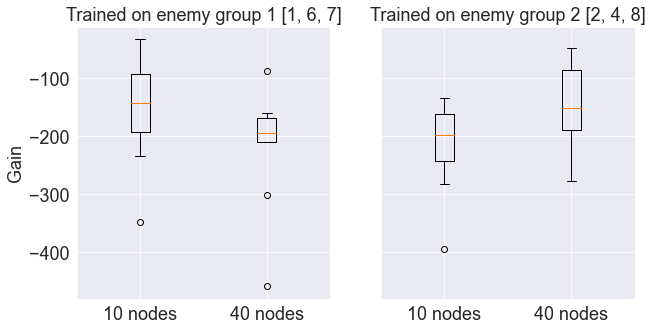

In [7]:
from matplotlib import rcParams
labelsize = 18
rcParams['xtick.labelsize'] = labelsize
rcParams['ytick.labelsize'] = labelsize

sns.set_style("darkgrid")
os.chdir('/Users/jorrimprins/Documents/Evoman_EC/group44-part2/')
best_IG = pd.read_csv('total_IG_data.csv', index_col=0)
fig, ax = plt.subplots(1, 2, figsize=(10,5),sharey=True)
labels = ['10 nodes', '40 nodes']
ax[0].boxplot([best_IG['10nodes[1, 6, 7]'],best_IG['40nodes[1, 6, 7]']], labels=labels) 
ax[1].boxplot([best_IG['10nodes[2, 4, 8]'],best_IG['40nodes[2, 4, 8]']], labels=labels) 
ax[0].set_title('Trained on enemy group 1 [1, 6, 7]',fontsize=18)
ax[1].set_title('Trained on enemy group 2 [2, 4, 8]',fontsize=18)
ax[0].set_ylabel('Gain',fontsize=18)
plt.savefig('Boxplot_IG.pdf',dpi=100)

### Lineplots 
First transform data and then plot

In [9]:
def std_list(rep,column):
    mylist = list()
    for df in rep:
        x = df[column].values
        mylist.append(x)
    return mylist  

os.chdir('/Users/jorrimprins/Documents/Evoman_EC/group44-part2/Data')
replist1 = []
replist2 = []
replist3 = []
replist4 = []

for i in range(10):
    replist1.append(pd.read_csv("10nodes[1, 6, 7]"+'/rep'+str(i)+'/fitstats.csv', delimiter = ',', index_col = 0))
    replist2.append(pd.read_csv("40nodes[1, 6, 7]"+'/rep'+str(i)+'/fitstats.csv', delimiter = ',', index_col = 0))
    replist3.append(pd.read_csv("10nodes[2, 4, 8]"+'/rep'+str(i)+'/fitstats.csv', delimiter = ',', index_col = 0))
    replist4.append(pd.read_csv("40nodes[2, 4, 8]"+'/rep'+str(i)+'/fitstats.csv', delimiter = ',', index_col = 0))

avg_data, best_data, std_data = std_list(replist1, 'Avg fitness'), std_list(replist1, 'Best fitness'), std_list(replist1, 'Std fitness')
avg_data, best_data, std_data = pd.DataFrame(avg_data).T, pd.DataFrame(best_data).T, pd.DataFrame(std_data).T
avg_data['mean'] = avg_data.mean(axis=1)
best_data['best_mean'] = best_data.mean(axis=1)
std_data['std_mean'] = std_data.mean(axis=1)
std_data['Generation'] = std_data.index
std = pd.concat([std_data['Generation'],std_data['std_mean'], best_data['best_mean']], axis=1)
avg_data, best_data = avg_data.iloc[:,-1:], best_data.iloc[:,-1:]

avg_data2, best_data2, std_data2 = std_list(replist2, 'Avg fitness'), std_list(replist2, 'Best fitness'), std_list(replist2, 'Std fitness')
avg_data2, best_data2, std_data2 = pd.DataFrame(avg_data2).T, pd.DataFrame(best_data2).T, pd.DataFrame(std_data2).T
avg_data2['mean'] = avg_data2.mean(axis=1)
best_data2['best_mean'] = best_data2.mean(axis=1)
std_data2['std_mean'] = std_data2.mean(axis=1)
std_data2['Generation'] = std_data2.index
std2 = pd.concat([std_data2['Generation'],std_data2['std_mean'], best_data2['best_mean']], axis=1)
avg_data2, best_data2 = avg_data2.iloc[:,-1:], best_data2.iloc[:,-1:]

avg_data3, best_data3, std_data3 = std_list(replist3, 'Avg fitness'), std_list(replist3, 'Best fitness'), std_list(replist3, 'Std fitness')
avg_data3, best_data3, std_data3 = pd.DataFrame(avg_data3).T, pd.DataFrame(best_data3).T, pd.DataFrame(std_data3).T
avg_data3['mean'] = avg_data3.mean(axis=1)
best_data3['best_mean'] = best_data3.mean(axis=1)
std_data3['std_mean'] = std_data3.mean(axis=1)
std_data3['Generation'] = std_data3.index
std3 = pd.concat([std_data3['Generation'],std_data3['std_mean'], best_data3['best_mean']], axis=1)
avg_data3, best_data3 = avg_data3.iloc[:,-1:], best_data3.iloc[:,-1:]

avg_data4, best_data4, std_data4 = std_list(replist4, 'Avg fitness'), std_list(replist4, 'Best fitness'), std_list(replist4, 'Std fitness')
avg_data4, best_data4, std_data4 = pd.DataFrame(avg_data4).T, pd.DataFrame(best_data4).T, pd.DataFrame(std_data4).T
avg_data4['mean'] = avg_data4.mean(axis=1)
best_data4['best_mean'] = best_data4.mean(axis=1)
std_data4['std_mean'] = std_data4.mean(axis=1)
std_data4['Generation'] = std_data4.index
std4 = pd.concat([std_data4['Generation'],std_data4['std_mean'], best_data4['best_mean']], axis=1)
avg_data4, best_data4 = avg_data4.iloc[:,-1:], best_data4.iloc[:,-1:]


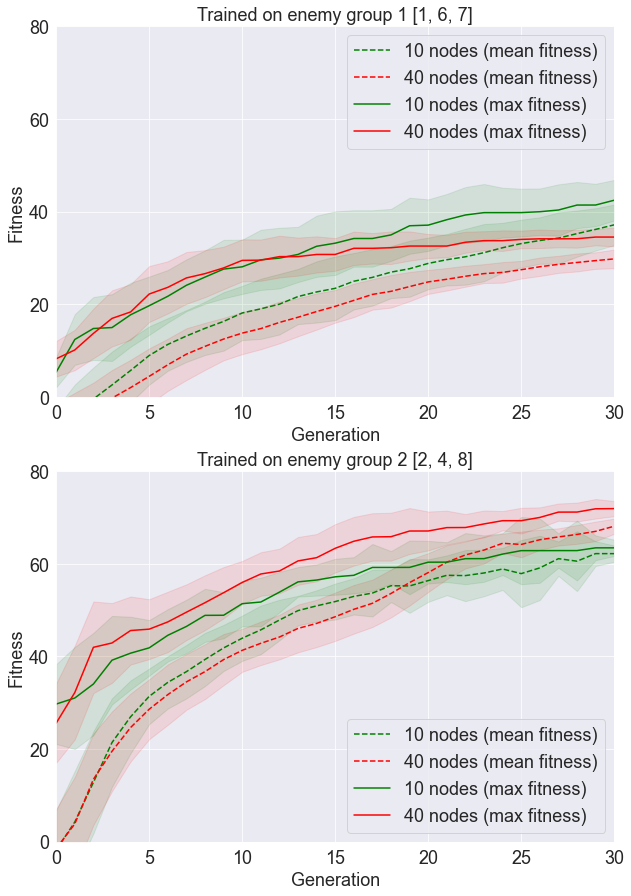

In [13]:
sns.set_style("darkgrid")
fig, im = plt.subplots(2, 1, sharex=False,figsize=(10,15))
im[0].plot(std_data['Generation'],avg_data['mean'], 'g--')
im[0].fill_between(x = 'Generation', y1 = avg_data['mean']-std['std_mean'], y2 = avg_data['mean']+std['std_mean'], data=std, alpha=0.1,color='g')
im[0].plot(std_data2['Generation'],avg_data2['mean'], 'r--')
im[0].fill_between(x = 'Generation', y1 = avg_data2['mean']-std2['std_mean'], y2 = avg_data2['mean']+std2['std_mean'], data=std2, alpha=0.1,color='r')
im[0].plot(std_data['Generation'],best_data['best_mean'], 'g-')
im[0].fill_between(x = 'Generation', y1 = best_data['best_mean']-std['std_mean'], y2 = best_data['best_mean']+std['std_mean'], data=std, alpha=0.1,color='g')
im[0].plot(std_data2['Generation'],best_data2['best_mean'], 'r-')
im[0].fill_between(x = 'Generation', y1 = best_data2['best_mean']-std2['std_mean'], y2 = best_data2['best_mean']+std2['std_mean'], data=std2, alpha=0.1,color='r')

im[1].plot(std_data3['Generation'],avg_data3['mean'], 'g--')
im[1].fill_between(x = 'Generation', y1 = avg_data3['mean']-std3['std_mean'], y2 = avg_data3['mean']+std3['std_mean'], data=std3, alpha=0.1,color='g')
im[1].plot(std_data4['Generation'],avg_data4['mean'], 'r--')
im[1].fill_between(x = 'Generation', y1 = avg_data4['mean']-std4['std_mean'], y2 = avg_data4['mean']+std4['std_mean'], data=std4, alpha=0.1,color='r')
im[1].plot(std_data3['Generation'],best_data3['best_mean'], 'g-')
im[1].fill_between(x = 'Generation', y1 = best_data3['best_mean']-std3['std_mean'], y2 = best_data3['best_mean']+std3['std_mean'], data=std3, alpha=0.1,color='g')
im[1].plot(std_data4['Generation'],best_data4['best_mean'], 'r-')
im[1].fill_between(x = 'Generation', y1 = best_data4['best_mean']-std4['std_mean'], y2 = best_data4['best_mean']+std4['std_mean'], data=std4, alpha=0.1,color='r')

for i in range(2):
    im[i].set_xlabel('Generation', fontsize=18)
    im[i].set_yticklabels(np.round(np.arange(0,100,20),0),fontsize=18)
    im[i].set_yticks(np.round(np.arange(0,100,20),0))
    im[i].set_ylim((-0.05,80))
    im[i].set_xticks(np.round(np.arange(0,45,5),0))
    im[i].set_xticklabels(np.round(np.arange(0,45,5),0),fontsize=18)
    im[i].set_xlim((0,30))

plt.subplots_adjust(hspace=0.2)
im[0].set_title('Trained on enemy group 1 [1, 6, 7]',fontsize=18)
im[1].set_title('Trained on enemy group 2 [2, 4, 8]',fontsize=18)
im[0].set_ylabel('Fitness', fontsize=18)
im[1].set_ylabel('Fitness', fontsize=18)
im[1].legend(labels=['10 nodes (mean fitness)','40 nodes (mean fitness)','10 nodes (max fitness)',
                     '40 nodes (max fitness)'],loc='lower right',fontsize=18)
im[0].legend(labels=['10 nodes (mean fitness)','40 nodes (mean fitness)','10 nodes (max fitness)',
                     '40 nodes (max fitness)'],loc='upper right',fontsize=18)

plt.savefig('Lineplot.pdf',dpi=100)


### Create results for final best individuals

In [7]:
os.chdir('/Users/jorrimprins/Documents/Evoman_EC/group44-part2/')
ultimate_sol = np.array(pd.read_csv('10nodes[1, 6, 7]/best_indivs.csv', delimiter = ',', index_col = 0).iloc[6,])
competition_sol = np.array(pd.read_csv('10nodes[1, 6, 7]/best_indivs.csv', delimiter = ',', index_col = 0).iloc[5,])

os.chdir('/Users/jorrimprins/Documents/Evoman_EC')

no_nodes=10
enemies = list(map(int,np.arange(1,9)))
life_array = np.zeros((8))
enem_array = np.zeros((8))
for j in range(5):
    for enemy in enemies:
        env = Environment(experiment_name='hi',
                          enemies=[enemy],multiplemode="no",playermode="ai",
                            player_controller=player_controller(no_nodes),
                            enemymode="static",level=2,speed="fastest",logs ='off')
        fit, play, enem, time = env.play(pcont=ultimate_sol)
        life_array[enemy-1] += play/5
        enem_array[enemy-1] += enem/5

os.chdir('/Users/jorrimprins/Documents/Evoman_EC/group44-part2/')
np.savetxt('best.txt',competition_sol)
pd.DataFrame({'life':life_array,'enem':enem_array}).to_csv('best_outcomes.csv')